In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 322
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=50

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3

# METHOD = "IR" # identical_random
# METHOD = "DR" # different_random

DATASET_DIR_NAME = "dataset\set02\\01_original"
SAMPLE_DATASET_NAME = "train"
# ACTUAL_DATASET_NAME = "test"

MODEL_DIR_NAME = "dataset\set02\\01_original"
MODEL_NAME = "model_" + "set02_01_original"

# RESULT_DIR_NAME = "dataset\set02\\01_original"
# RESULT_NAME = "result_" + "set02_01_original"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
# ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

# RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
# RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set02\01_original
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set02\01_original
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set02\01_original\train.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,...,T9-RF|VAR,T9-NG|VAR,T9-I|SD,T9-PF|SD,T9-RF|SD,T9-NG|SD,T10-I|0+9,T10-PF|0+9,T10-RF|0+9,T10-NG|0+9
0,adhy,3,ohm filmed,0.154125,0.093798,0.247924,0.232284,0.386410,0.138486,0.300717,...,0.002393,0.001434,0.037765,0.026706,0.048922,0.037863,1.804767,1.958893,1.936692,2.090818
1,adhy,4,heat atoms,0.185183,0.253542,0.438725,0.385330,0.570513,0.131788,0.285710,...,0.057276,0.076773,0.190323,0.228078,0.239324,0.277080,1.389586,1.574769,1.505635,1.690818
2,adhy,5,chant axis,0.147403,-0.069143,0.078260,0.068697,0.216100,0.137840,0.015532,...,0.005058,0.004142,0.093102,0.086340,0.071119,0.064357,1.256483,1.403886,1.372666,1.520069
3,adhy,6,oldies bay,0.116146,0.185094,0.301241,0.347630,0.463776,0.162536,0.037921,...,0.030531,0.020144,0.126528,0.093725,0.174730,0.141928,1.488371,1.604517,1.604610,1.720756
4,adhy,3,gym zygote,0.137315,-0.084266,0.053049,0.015728,0.153044,0.099994,0.169676,...,0.002392,0.000507,0.048903,0.022514,0.048912,0.022522,1.188967,1.326283,1.320779,1.458094


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


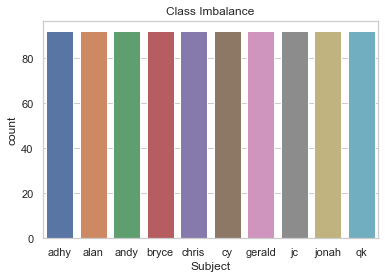

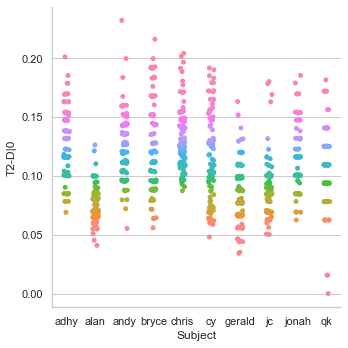

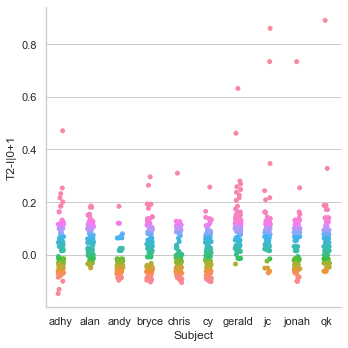

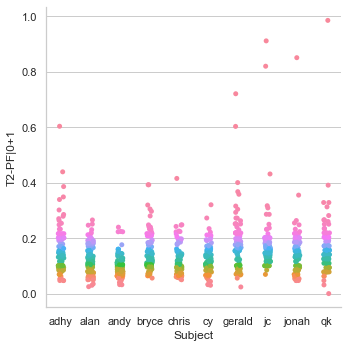

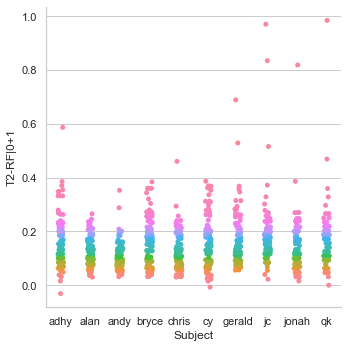

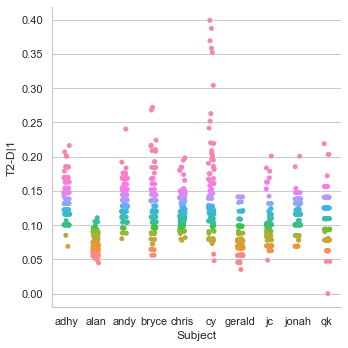

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['adhy' 'alan' 'andy' 'bryce' 'chris' 'cy' 'gerald' 'jc' 'jonah' 'qk']


X | Features | Dataset Shape: (920, 322)
Y | Classes  | Dataset Shape: (920, 10)
Number of Classes: 10


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (736, 1, 322)
Y train shape: (736, 10)
X test shape: (184, 1, 322)
Y test shape: (184, 10)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 10 classes.
Epoch 1/200
12/12 [==============================] - 7s 13ms/step - loss: 2.4573 - accuracy: 0.1088
Epoch 2/200
12/12 [==============================] - 0s 12ms/step - loss: 2.4083 - accuracy: 0.1020
Epoch 3/200
12/12 [==============================] - 0s 13ms/step - loss: 2.3834 - accuracy: 0.1020
Epoch 4/200
12/12 [==============================] - 0s 13ms/step - loss: 2.3773 - accuracy: 0.0748
Epoch 5/200
12/12 [==============================] - 0s 14ms/step - loss: 2.3591 - accuracy: 0.0918
Epoch 6/200
12/12 [==============================] - 0s 14ms/step - loss: 2.3300 - accuracy: 0.1207
Epoch 7/200
12/12 [==============================] - 0s 14ms/step - loss: 2.3431 - accuracy: 0.0969
Epoch 8/200
12/12 [==============================] - 0s 16ms/step - loss: 2.3451 - accuracy: 0.0935
Epoch 9/200
12/12 [==============================] - 0s 15ms/step - loss: 2.3228 - accuracy: 0.1310
Epoch 10/200
12/12 [==============================] - 0s 15ms/step 

12/12 [==============================] - 0s 13ms/step - loss: 1.5836 - accuracy: 0.3452
Epoch 82/200
12/12 [==============================] - 0s 13ms/step - loss: 1.6136 - accuracy: 0.3163
Epoch 83/200
12/12 [==============================] - 0s 13ms/step - loss: 1.6606 - accuracy: 0.3299
Epoch 84/200
12/12 [==============================] - 0s 13ms/step - loss: 1.6481 - accuracy: 0.3044
Epoch 85/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5744 - accuracy: 0.3384
Epoch 86/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5687 - accuracy: 0.3844
Epoch 87/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5770 - accuracy: 0.3759
Epoch 88/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5441 - accuracy: 0.3861
Epoch 89/200
12/12 [==============================] - 0s 16ms/step - loss: 1.5710 - accuracy: 0.3707
Epoch 90/200
12/12 [==============================] - 0s 18ms/step - loss: 1.5861 - accuracy: 0.3503
Epo

12/12 [==============================] - 0s 14ms/step - loss: 1.5543 - accuracy: 0.3622
Epoch 162/200
12/12 [==============================] - 0s 17ms/step - loss: 1.5456 - accuracy: 0.3435
Epoch 163/200
12/12 [==============================] - 0s 16ms/step - loss: 1.4524 - accuracy: 0.4286
Epoch 164/200
12/12 [==============================] - 0s 14ms/step - loss: 1.4504 - accuracy: 0.4133
Epoch 165/200
12/12 [==============================] - 0s 14ms/step - loss: 1.4628 - accuracy: 0.4184
Epoch 166/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4877 - accuracy: 0.3878
Epoch 167/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4999 - accuracy: 0.4065
Epoch 168/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4937 - accuracy: 0.3946
Epoch 169/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4966 - accuracy: 0.3724
Epoch 170/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4530 - accuracy: 0

12/12 [==============================] - 0s 14ms/step - loss: 1.8103 - accuracy: 0.2683
Epoch 41/200
12/12 [==============================] - 0s 14ms/step - loss: 1.7892 - accuracy: 0.3039
Epoch 42/200
12/12 [==============================] - 0s 14ms/step - loss: 1.7750 - accuracy: 0.2835
Epoch 43/200
12/12 [==============================] - 0s 14ms/step - loss: 1.7558 - accuracy: 0.2835
Epoch 44/200
12/12 [==============================] - 0s 14ms/step - loss: 1.7681 - accuracy: 0.2988
Epoch 45/200
12/12 [==============================] - 0s 13ms/step - loss: 1.7589 - accuracy: 0.2767
Epoch 46/200
12/12 [==============================] - 0s 14ms/step - loss: 1.7539 - accuracy: 0.3056
Epoch 47/200
12/12 [==============================] - 0s 14ms/step - loss: 1.7148 - accuracy: 0.3141
Epoch 48/200
12/12 [==============================] - 0s 14ms/step - loss: 1.6833 - accuracy: 0.3379
Epoch 49/200
12/12 [==============================] - 0s 14ms/step - loss: 1.6955 - accuracy: 0.3056
Epo

12/12 [==============================] - 0s 13ms/step - loss: 1.5621 - accuracy: 0.3633
Epoch 122/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5269 - accuracy: 0.4092
Epoch 123/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5395 - accuracy: 0.3871
Epoch 124/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5493 - accuracy: 0.4007
Epoch 125/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5544 - accuracy: 0.4007
Epoch 126/200
12/12 [==============================] - 0s 14ms/step - loss: 1.6516 - accuracy: 0.3752
Epoch 127/200
12/12 [==============================] - 0s 14ms/step - loss: 1.6428 - accuracy: 0.3633
Epoch 128/200
12/12 [==============================] - 0s 16ms/step - loss: 1.5990 - accuracy: 0.3922
Epoch 129/200
12/12 [==============================] - 0s 17ms/step - loss: 1.5982 - accuracy: 0.3956
Epoch 130/200
12/12 [==============================] - 0s 20ms/step - loss: 1.6123 - accuracy: 0

3/3 [==============================] - 1s 5ms/step - loss: 1.5008 - accuracy: 0.4218
There are a total of 10 classes.
Epoch 1/200
12/12 [==============================] - 8s 14ms/step - loss: 2.4476 - accuracy: 0.0985
Epoch 2/200
12/12 [==============================] - 0s 14ms/step - loss: 2.4173 - accuracy: 0.0985
Epoch 3/200
12/12 [==============================] - 0s 16ms/step - loss: 2.3707 - accuracy: 0.1036
Epoch 4/200
12/12 [==============================] - 0s 16ms/step - loss: 2.3537 - accuracy: 0.1036
Epoch 5/200
12/12 [==============================] - 0s 15ms/step - loss: 2.3428 - accuracy: 0.1002
Epoch 6/200
12/12 [==============================] - 0s 15ms/step - loss: 2.3329 - accuracy: 0.1121
Epoch 7/200
12/12 [==============================] - 0s 15ms/step - loss: 2.3518 - accuracy: 0.0917
Epoch 8/200
12/12 [==============================] - 0s 16ms/step - loss: 2.3219 - accuracy: 0.1171
Epoch 9/200
12/12 [==============================] - 0s 14ms/step - loss: 2.2912 -

12/12 [==============================] - 0s 15ms/step - loss: 1.6075 - accuracy: 0.3548
Epoch 82/200
12/12 [==============================] - 0s 16ms/step - loss: 1.6307 - accuracy: 0.3463
Epoch 83/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5543 - accuracy: 0.3718
Epoch 84/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5811 - accuracy: 0.3463
Epoch 85/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5727 - accuracy: 0.3514
Epoch 86/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5963 - accuracy: 0.3362
Epoch 87/200
12/12 [==============================] - 0s 14ms/step - loss: 1.6052 - accuracy: 0.3616
Epoch 88/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5842 - accuracy: 0.3582
Epoch 89/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5864 - accuracy: 0.3684
Epoch 90/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5732 - accuracy: 0.3396
Epo

12/12 [==============================] - 0s 16ms/step - loss: 1.4321 - accuracy: 0.4211
Epoch 162/200
12/12 [==============================] - 0s 15ms/step - loss: 1.3906 - accuracy: 0.4278
Epoch 163/200
12/12 [==============================] - 0s 15ms/step - loss: 1.4534 - accuracy: 0.4126
Epoch 164/200
12/12 [==============================] - 0s 16ms/step - loss: 1.4287 - accuracy: 0.4414
Epoch 165/200
12/12 [==============================] - 0s 19ms/step - loss: 1.4174 - accuracy: 0.4228
Epoch 166/200
12/12 [==============================] - 0s 16ms/step - loss: 1.4263 - accuracy: 0.4194
Epoch 167/200
12/12 [==============================] - 0s 17ms/step - loss: 1.4228 - accuracy: 0.4278
Epoch 168/200
12/12 [==============================] - 0s 16ms/step - loss: 1.4498 - accuracy: 0.4007
Epoch 169/200
12/12 [==============================] - 0s 16ms/step - loss: 1.4280 - accuracy: 0.4228
Epoch 170/200
12/12 [==============================] - 0s 16ms/step - loss: 1.4548 - accuracy: 0

12/12 [==============================] - 0s 19ms/step - loss: 1.7327 - accuracy: 0.2649
Epoch 41/200
12/12 [==============================] - 0s 21ms/step - loss: 1.7345 - accuracy: 0.2903
Epoch 42/200
12/12 [==============================] - 0s 19ms/step - loss: 1.7514 - accuracy: 0.2937
Epoch 43/200
12/12 [==============================] - 0s 17ms/step - loss: 1.6971 - accuracy: 0.3260
Epoch 44/200
12/12 [==============================] - 0s 18ms/step - loss: 1.7122 - accuracy: 0.2937
Epoch 45/200
12/12 [==============================] - 0s 16ms/step - loss: 1.6963 - accuracy: 0.3073
Epoch 46/200
12/12 [==============================] - 0s 15ms/step - loss: 1.6837 - accuracy: 0.3209
Epoch 47/200
12/12 [==============================] - 0s 15ms/step - loss: 1.6782 - accuracy: 0.2920
Epoch 48/200
12/12 [==============================] - 0s 14ms/step - loss: 1.6856 - accuracy: 0.3124
Epoch 49/200
12/12 [==============================] - 0s 15ms/step - loss: 1.6724 - accuracy: 0.3073
Epo

12/12 [==============================] - 0s 14ms/step - loss: 1.4289 - accuracy: 0.4024
Epoch 122/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4370 - accuracy: 0.4244
Epoch 123/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4122 - accuracy: 0.3973
Epoch 124/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4174 - accuracy: 0.4397
Epoch 125/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4663 - accuracy: 0.4041
Epoch 126/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4631 - accuracy: 0.4024
Epoch 127/200
12/12 [==============================] - 0s 14ms/step - loss: 1.4281 - accuracy: 0.4346
Epoch 128/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4604 - accuracy: 0.4143
Epoch 129/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4230 - accuracy: 0.4109
Epoch 130/200
12/12 [==============================] - 0s 14ms/step - loss: 1.4281 - accuracy: 0

3/3 [==============================] - 2s 7ms/step - loss: 1.6025 - accuracy: 0.3673
There are a total of 10 classes.
Epoch 1/200
12/12 [==============================] - 7s 15ms/step - loss: 2.4900 - accuracy: 0.1036
Epoch 2/200
12/12 [==============================] - 0s 15ms/step - loss: 2.4562 - accuracy: 0.0934
Epoch 3/200
12/12 [==============================] - 0s 16ms/step - loss: 2.3833 - accuracy: 0.0951
Epoch 4/200
12/12 [==============================] - 0s 17ms/step - loss: 2.3741 - accuracy: 0.0900
Epoch 5/200
12/12 [==============================] - 0s 22ms/step - loss: 2.3615 - accuracy: 0.1053
Epoch 6/200
12/12 [==============================] - 0s 19ms/step - loss: 2.3359 - accuracy: 0.1087
Epoch 7/200
12/12 [==============================] - 0s 18ms/step - loss: 2.3294 - accuracy: 0.0900
Epoch 8/200
12/12 [==============================] - 0s 20ms/step - loss: 2.3284 - accuracy: 0.1070
Epoch 9/200
12/12 [==============================] - 0s 19ms/step - loss: 2.3437 -

12/12 [==============================] - 0s 15ms/step - loss: 1.5435 - accuracy: 0.3956
Epoch 82/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5858 - accuracy: 0.3854
Epoch 83/200
12/12 [==============================] - 0s 15ms/step - loss: 1.5370 - accuracy: 0.3990
Epoch 84/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5282 - accuracy: 0.3837
Epoch 85/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5441 - accuracy: 0.4092
Epoch 86/200
12/12 [==============================] - 0s 15ms/step - loss: 1.5437 - accuracy: 0.3990
Epoch 87/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5422 - accuracy: 0.4058
Epoch 88/200
12/12 [==============================] - 0s 16ms/step - loss: 1.5124 - accuracy: 0.4075
Epoch 89/200
12/12 [==============================] - 0s 16ms/step - loss: 1.5076 - accuracy: 0.3667
Epoch 90/200
12/12 [==============================] - 0s 15ms/step - loss: 1.4975 - accuracy: 0.4075
Epo

12/12 [==============================] - 0s 16ms/step - loss: 1.3802 - accuracy: 0.4312
Epoch 162/200
12/12 [==============================] - 0s 17ms/step - loss: 1.3876 - accuracy: 0.4601
Epoch 163/200
12/12 [==============================] - 0s 14ms/step - loss: 1.3914 - accuracy: 0.4482
Epoch 164/200
12/12 [==============================] - 0s 14ms/step - loss: 1.3590 - accuracy: 0.4533
Epoch 165/200
12/12 [==============================] - 0s 15ms/step - loss: 1.3983 - accuracy: 0.4465
Epoch 166/200
12/12 [==============================] - 0s 14ms/step - loss: 1.4322 - accuracy: 0.4228
Epoch 167/200
12/12 [==============================] - 0s 14ms/step - loss: 1.4048 - accuracy: 0.4448
Epoch 168/200
12/12 [==============================] - 0s 14ms/step - loss: 1.4323 - accuracy: 0.4550
Epoch 169/200
12/12 [==============================] - 0s 14ms/step - loss: 1.4022 - accuracy: 0.4363
Epoch 170/200
12/12 [==============================] - 0s 13ms/step - loss: 1.3459 - accuracy: 0

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 38.86% (with standard deviation of 2.64%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 10 classes.
Epoch 1/200
15/15 [==============================] - 6s 14ms/step - loss: 2.4088 - accuracy: 0.1060
Epoch 2/200
15/15 [==============================] - 0s 13ms/step - loss: 2.3655 - accuracy: 0.1033
Epoch 3/200
15/15 [==============================] - 0s 13ms/step - loss: 2.3496 - accuracy: 0.1209
Epoch 4/200
15/15 [==============================] - 0s 14ms/step - loss: 2.3483 - accuracy: 0.1033
Epoch 5/200
15/15 [==============================] - 0s 15ms/step - loss: 2.3245 - accuracy: 0.1073
Epoch 6/200
15/15 [==============================] - 0s 15ms/step - loss: 2.3385 - accuracy: 0.1073
Epoch 7/200
15/15 [==============================] - 0s 16ms/step - loss: 2.3307 - accuracy: 0.1101
Epoch 8/200
15/15 [==============================] - 0s 16ms/step - loss: 2.3318 - accuracy: 0.1073
Epoch 9/200
15/15 [==============================] - 0s 16ms/step - loss: 2.3148 - accuracy: 0.1304
Epoch 10/200
15/15 [==============================] - 0s 15ms/step 

15/15 [==============================] - 0s 14ms/step - loss: 1.5027 - accuracy: 0.4090
Epoch 82/200
15/15 [==============================] - 0s 14ms/step - loss: 1.5260 - accuracy: 0.3533
Epoch 83/200
15/15 [==============================] - 0s 15ms/step - loss: 1.4942 - accuracy: 0.4035
Epoch 84/200
15/15 [==============================] - 0s 15ms/step - loss: 1.5481 - accuracy: 0.3872
Epoch 85/200
15/15 [==============================] - 0s 14ms/step - loss: 1.5105 - accuracy: 0.3804
Epoch 86/200
15/15 [==============================] - 0s 14ms/step - loss: 1.5302 - accuracy: 0.4022
Epoch 87/200
15/15 [==============================] - 0s 21ms/step - loss: 1.4845 - accuracy: 0.4062
Epoch 88/200
15/15 [==============================] - 0s 17ms/step - loss: 1.5529 - accuracy: 0.3804
Epoch 89/200
15/15 [==============================] - 0s 20ms/step - loss: 1.5103 - accuracy: 0.3954
Epoch 90/200
15/15 [==============================] - 0s 19ms/step - loss: 1.5018 - accuracy: 0.3832
Epo

15/15 [==============================] - 0s 14ms/step - loss: 1.3886 - accuracy: 0.4389
Epoch 162/200
15/15 [==============================] - 0s 14ms/step - loss: 1.3393 - accuracy: 0.4552
Epoch 163/200
15/15 [==============================] - 0s 14ms/step - loss: 1.3938 - accuracy: 0.4280
Epoch 164/200
15/15 [==============================] - 0s 17ms/step - loss: 1.3777 - accuracy: 0.4402
Epoch 165/200
15/15 [==============================] - 0s 16ms/step - loss: 1.3594 - accuracy: 0.4375
Epoch 166/200
15/15 [==============================] - 0s 16ms/step - loss: 1.3175 - accuracy: 0.4633
Epoch 167/200
15/15 [==============================] - 0s 14ms/step - loss: 1.3575 - accuracy: 0.4511
Epoch 168/200
15/15 [==============================] - 0s 14ms/step - loss: 1.3956 - accuracy: 0.4158
Epoch 169/200
15/15 [==============================] - 0s 16ms/step - loss: 1.3552 - accuracy: 0.4416
Epoch 170/200
15/15 [==============================] - 0s 15ms/step - loss: 1.4024 - accuracy: 0

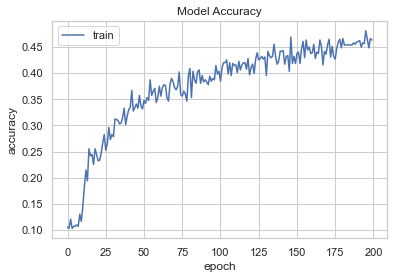

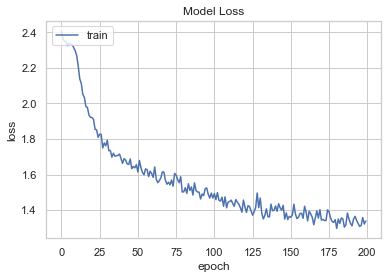

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            592896    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 46.196%


##### Confusion Matrix

184 is the number of test value in kfold_val / train_test_split


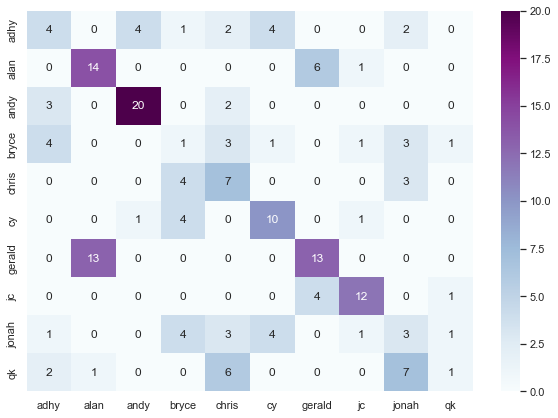

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

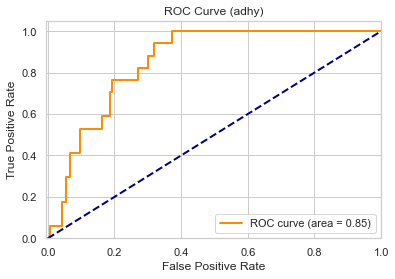

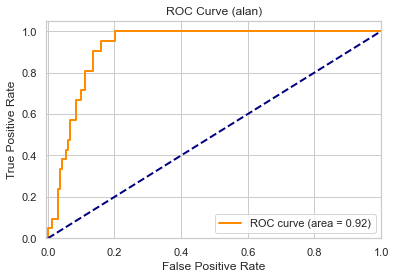

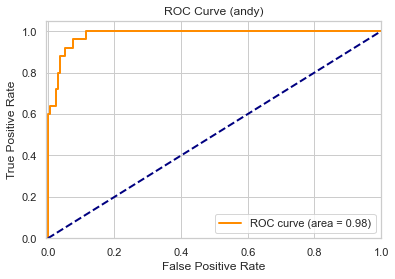

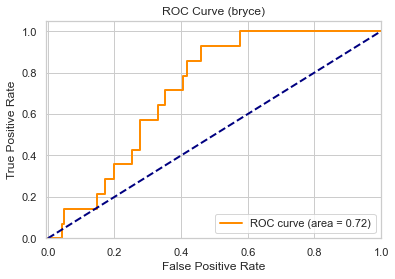

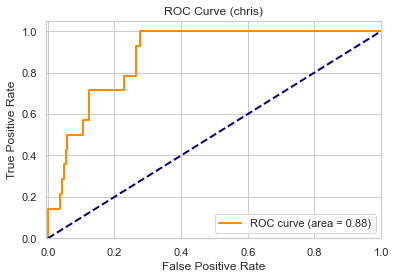

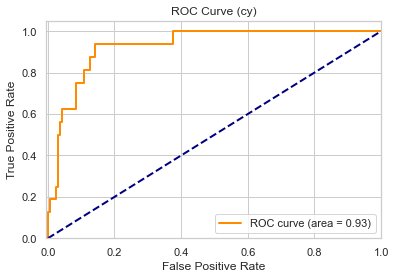

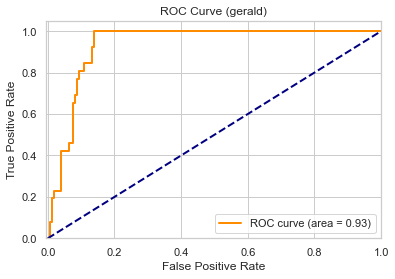

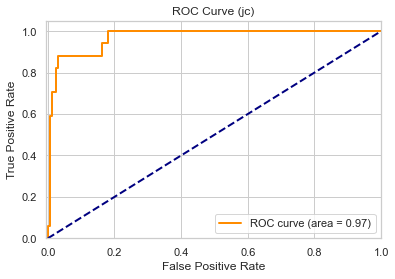

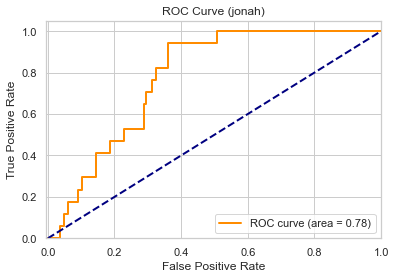

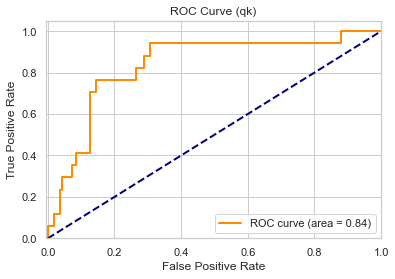

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

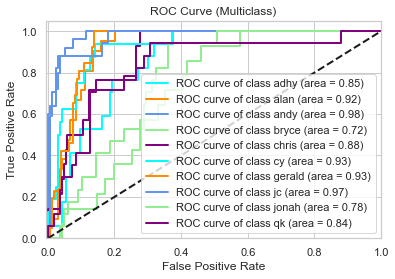

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

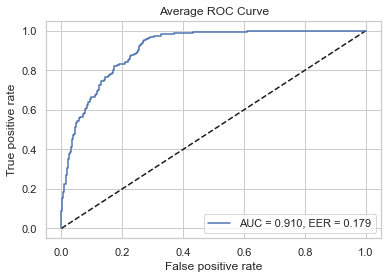

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'alan' 'andy' 'bryce' 'chris' 'cy' 'gerald' 'jc' 'jonah' 'qk']


X | Features | Dataset Shape: (920, 322)
Y | Classes  | Dataset Shape: (920, 10)
There are a total of 10 classes.
Epoch 1/200
19/19 [==============================] - 7s 13ms/step - loss: 2.4365 - accuracy: 0.1000
Epoch 2/200
19/19 [==============================] - 0s 15ms/step - loss: 2.3883 - accuracy: 0.0880
Epoch 3/200
19/19 [==============================] - 0s 16ms/step - loss: 2.3495 - accuracy: 0.0761
Epoch 4/200
19/19 [==============================] - 0s 15ms/step - loss: 2.3611 - accuracy: 0.0880
Epoch 5/200
19/19 [==============================] - 0s 15ms/step - loss: 2.3477 - accuracy: 0.0989
Epoch 6/200
19/19 [==============================] - 0s 15ms/step - loss: 2.3311 - accuracy: 0.0967
Epoch 7/200
19/19 [==============================] - 0s 15ms/step - loss: 2.2829 - accuracy: 0.1598
Epoch 8/200
19/19 [==============================] - 0s 16ms/step - loss: 2.

Epoch 80/200
19/19 [==============================] - 0s 15ms/step - loss: 1.4576 - accuracy: 0.4022
Epoch 81/200
19/19 [==============================] - 0s 15ms/step - loss: 1.5048 - accuracy: 0.3902
Epoch 82/200
19/19 [==============================] - 0s 15ms/step - loss: 1.4163 - accuracy: 0.4337
Epoch 83/200
19/19 [==============================] - 0s 15ms/step - loss: 1.4245 - accuracy: 0.4326
Epoch 84/200
19/19 [==============================] - 0s 15ms/step - loss: 1.4162 - accuracy: 0.4109
Epoch 85/200
19/19 [==============================] - 0s 15ms/step - loss: 1.4091 - accuracy: 0.4250
Epoch 86/200
19/19 [==============================] - 0s 15ms/step - loss: 1.4289 - accuracy: 0.4109
Epoch 87/200
19/19 [==============================] - 0s 15ms/step - loss: 1.4268 - accuracy: 0.4152
Epoch 88/200
19/19 [==============================] - 0s 15ms/step - loss: 1.4259 - accuracy: 0.4304
Epoch 89/200
19/19 [==============================] - 0s 15ms/step - loss: 1.4105 - accurac

19/19 [==============================] - 0s 14ms/step - loss: 1.3104 - accuracy: 0.4935
Epoch 161/200
19/19 [==============================] - 0s 14ms/step - loss: 1.2908 - accuracy: 0.4815
Epoch 162/200
19/19 [==============================] - 0s 15ms/step - loss: 1.3183 - accuracy: 0.4804
Epoch 163/200
19/19 [==============================] - 0s 15ms/step - loss: 1.3029 - accuracy: 0.4848
Epoch 164/200
19/19 [==============================] - 0s 15ms/step - loss: 1.2906 - accuracy: 0.4663
Epoch 165/200
19/19 [==============================] - 0s 16ms/step - loss: 1.3255 - accuracy: 0.4739
Epoch 166/200
19/19 [==============================] - 0s 16ms/step - loss: 1.3158 - accuracy: 0.4728
Epoch 167/200
19/19 [==============================] - 0s 15ms/step - loss: 1.3034 - accuracy: 0.4870
Epoch 168/200
19/19 [==============================] - 0s 14ms/step - loss: 1.2816 - accuracy: 0.4924
Epoch 169/200
19/19 [==============================] - 0s 13ms/step - loss: 1.2991 - accuracy: 0

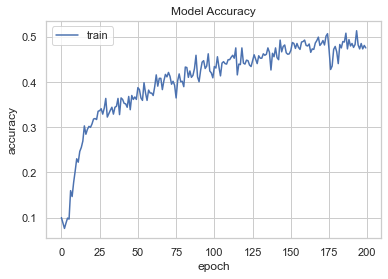

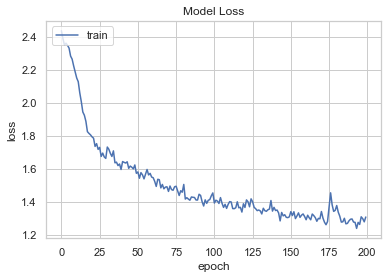

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING FOR IR
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
METHOD = "IR" # identical_random
# METHOD = "DR" # different_random

DATASET_DIR_NAME = "dataset\set02\\01_original"
ACTUAL_DATASET_NAME = "test_" + METHOD
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

RESULT_DIR_NAME = "dataset\set02\\01_original"
RESULT_NAME = "result_" + "set02_01_original_" + METHOD
RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,...,T9-RF|VAR,T9-NG|VAR,T9-I|SD,T9-PF|SD,T9-RF|SD,T9-NG|SD,T10-I|0+9,T10-PF|0+9,T10-RF|0+9,T10-NG|0+9
0,adhy,3,use volume,0.138573,-0.084819,0.053754,0.084257,0.222830,0.169076,-0.100031,...,0.000018,3.003560e-04,0.015400,0.006169,0.004238,0.017331,1.367618,1.506191,1.468137,1.606710
1,adhy,4,yale zonks,0.069259,-0.015698,0.053560,0.084381,0.153640,0.100079,0.031206,...,0.000478,3.870000e-09,0.022083,0.043876,0.021856,0.000062,0.802144,0.871402,0.871176,0.940435
2,adhy,5,handy iron,0.084898,-0.015655,0.069243,0.115984,0.200882,0.131639,-0.015518,...,0.003094,5.096550e-04,0.011010,0.022040,0.055626,0.022576,0.904103,0.989002,0.988245,1.073144
3,adhy,6,inbred gem,0.100523,0.116285,0.216808,0.216809,0.317332,0.100524,0.100347,...,0.018903,1.890288e-02,0.093657,0.093656,0.137488,0.137488,1.119189,1.219711,1.203950,1.304473
4,adhy,3,taw kungfu,0.146900,-0.031359,0.115541,0.185035,0.331935,0.216394,-0.115934,...,0.014350,4.991602e-03,0.081778,0.032639,0.119791,0.070651,1.087014,1.233914,1.171835,1.318736


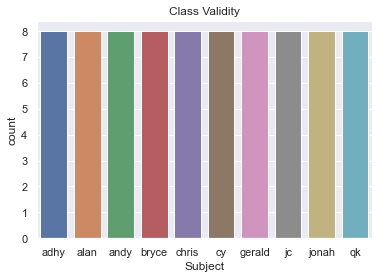

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

ir_result = "Accuracy of the Model for IR dataset is: " + str(match_header)
print(ir_result)

Accuracy of the Model for IR dataset is: 32/80 (40.0%)


# LIVE TESTING FOR DR
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [32]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [33]:
# METHOD = "IR" # identical_random
METHOD = "DR" # different_random

ACTUAL_DATASET_NAME = "test_" + METHOD
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

RESULT_DIR_NAME = "dataset\set02\\01_original"
RESULT_NAME = "result_" + "set02_01_original_" + METHOD
RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,T2-RF|1+2,T2-NG|1+2,T2-D|2,T2-I|2+3,T2-PF|2+3,T2-RF|2+3,T2-NG|2+3,T2-D|3,T2-I|3+4,T2-PF|3+4,T2-RF|3+4,T2-NG|3+4,T2-D|4,T2-I|4+5,T2-PF|4+5,T2-RF|4+5,T2-NG|4+5,T2-D|5,T2-I|5+6,T2-PF|5+6,T2-RF|5+6,T2-NG|5+6,T2-D|6,T2-I|6+7,T2-PF|6+7,T2-RF|6+7,T2-NG|6+7,T2-D|7,T2-I|7+8,T2-PF|7+8,T2-RF|7+8,T2-NG|7+8,T2-D|8,T2-I|8+9,T2-PF|8+9,T2-RF|8+9,T2-NG|8+9,T2-D|9,T2-D|S,T2-I|S,T2-PF|S,T2-RF|S,T2-NG|S,T2-D|M,T2-I|M,T2-PF|M,T2-RF|M,T2-DT-M,T2-D|VAR,T2-I|VAR,T2-PF|VAR,T2-RF|VAR,T2-DT-VAR,T2-D|SD,T2-I|SD,T2-PF|SD,T2-RF|SD,T2-NG|SD,T3-I|0+2,T3-PF|0+2,T3-RF|0+2,T3-NG|0+2,T3-I|1+3,T3-PF|1+3,T3-RF|1+3,T3-NG|1+3,T3-I|2+4,T3-PF|2+4,T3-RF|2+4,T3-NG|2+4,T3-I|3+5,T3-PF|3+5,T3-RF|3+5,T3-NG|3+5,T3-I|4+6,T3-PF|4+6,T3-RF|4+6,T3-NG|4+6,T3-I|5+7,T3-PF|5+7,T3-RF|5+7,T3-NG|5+7,T3-I|6+8,T3-PF|6+8,T3-RF|6+8,T3-NG|6+8,T3-I|7+9,T3-PF|7+9,T3-RF|7+9,T3-NG|7+9,T3-I|S,T3-PF|S,T3-RF|S,T3-NG|S,T3-I|M,T3-PF|M,T3-RF|M,T3-NG|M,T3-I|VAR,T3-PF|VAR,T3-RF|VAR,T3-NG|VAR,T3-I|SD,T3-PF|SD,T3-RF|SD,T3-NG|SD,T4-I|0+3,T4-PF|0+3,T4-RF|0+3,T4-NG|0+3,T4-I|1+4,T4-PF|1+4,T4-RF|1+4,T4-NG|1+4,T4-I|2+5,T4-PF|2+5,T4-RF|2+5,T4-NG|2+5,T4-I|3+6,T4-PF|3+6,T4-RF|3+6,T4-NG|3+6,T4-I|4+7,T4-PF|4+7,T4-RF|4+7,T4-NG|4+7,T4-I|5+8,T4-PF|5+8,T4-RF|5+8,T4-NG|5+8,T4-I|6+9,T4-PF|6+9,T4-RF|6+9,T4-NG|6+9,T4-I|S,T4-PF|S,T4-RF|S,T4-NG|S,T4-I|M,T4-PF|M,T4-RF|M,T4-NG|M,T4-I|VAR,T4-PF|VAR,T4-RF|VAR,T4-NG|VAR,T4-I|SD,T4-PF|SD,T4-RF|SD,T4-NG|SD,T5-I|0+4,T5-PF|0+4,T5-RF|0+4,T5-NG|0+4,T5-I|1+5,T5-PF|1+5,T5-RF|1+5,T5-NG|1+5,T5-I|2+6,T5-PF|2+6,T5-RF|2+6,T5-NG|2+6,T5-I|3+7,T5-PF|3+7,T5-RF|3+7,T5-NG|3+7,T5-I|4+8,T5-PF|4+8,T5-RF|4+8,T5-NG|4+8,T5-I|5+9,T5-PF|5+9,T5-RF|5+9,T5-NG|5+9,T5-I|S,T5-PF|S,T5-RF|S,T5-NG|S,T5-I|M,T5-PF|M,T5-RF|M,T5-NG|M,T5-I|VAR,T5-PF|VAR,T5-RF|VAR,T5-NG|VAR,T5-I|SD,T5-PF|SD,T5-RF|SD,T5-NG|SD,T6-I|0+5,T6-PF|0+5,T6-RF|0+5,T6-NG|0+5,T6-I|1+6,T6-PF|1+6,T6-RF|1+6,T6-NG|1+6,T6-I|2+7,T6-PF|2+7,T6-RF|2+7,T6-NG|2+7,T6-I|3+8,T6-PF|3+8,T6-RF|3+8,T6-NG|3+8,T6-I|4+9,T6-PF|4+9,T6-RF|4+9,T6-NG|4+9,T6-I|S,T6-PF|S,T6-RF|S,T6-NG|S,T6-I|M,T6-PF|M,T6-RF|M,T6-NG|M,T6-I|VAR,T6-PF|VAR,T6-RF|VAR,T6-NG|VAR,T6-I|SD,T6-PF|SD,T6-RF|SD,T6-NG|SD,T7-I|0+6,T7-PF|0+6,T7-RF|0+6,T7-NG|0+6,T7-I|1+7,T7-PF|1+7,T7-RF|1+7,T7-NG|1+7,T7-I|2+8,T7-PF|2+8,T7-RF|2+8,T7-NG|2+8,T7-I|3+9,T7-PF|3+9,T7-RF|3+9,T7-NG|3+9,T7-I|S,T7-PF|S,T7-RF|S,T7-NG|S,T7-I|M,T7-PF|M,T7-RF|M,T7-NG|M,T7-I|VAR,T7-PF|VAR,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7,T8-I|1+8,T8-PF|1+8,T8-RF|1+8,T8-NG|1+8,T8-I|2+9,T8-PF|2+9,T8-RF|2+9,T8-NG|2+9,T8-I|S,T8-PF|S,T8-RF|S,T8-NG|S,T8-I|M,T8-PF|M,T8-RF|M,T8-NG|M,T8-I|VAR,T8-PF|VAR,T8-RF|VAR,T8-NG|VAR,T8-I|SD,T8-PF|SD,T8-RF|SD,T8-NG|SD,T9-I|0+8,T9-PF|0+8,T9-RF|0+8,T9-NG|0+8,T9-I|1+9,T9-PF|1+9,T9-RF|1+9,T9-NG|1+9,T9-I|S,T9-PF|S,T9-RF|S,T9-NG|S,T9-I|M,T9-PF|M,T9-RF|M,T9-NG|M,T9-I|VAR,T9-PF|VAR,T9-RF|VAR,T9-NG|VAR,T9-I|SD,T9-PF|SD,T9-RF|SD,T9-NG|SD,T10-I|0+9,T10-PF|0+9,T10-RF|0+9,T10-NG|0+9
0,adhy,3,yup doodad,0.138363,0.194245,0.332608,0.363479,0.501841,0.169233,-0.084397,0.084837,0.116071,0.285304,0.200467,-0.015717,0.184750,0.122536,0.323003,0.138253,0.031293,0.169546,0.116290,0.254543,0.084997,0.031187,0.116184,0.100498,0.185495,0.069311,0.031251,0.100562,0.147211,0.216522,0.115960,0.068703,0.184663,0.184861,0.300821,0.116158,0.031137,0.147295,0.153954,0.270112,0.122817,-0.053428,0.069389,0.100364,0.223181,0.153792,1.309352,0.234274,1.389833,1.405263,2.560822,0.130935,0.026030,0.154426,0.156140,0.284536,0.001483,0.006309,0.006287,0.006804,0.008534,0.038513,0.079432,0.079294,0.082484,0.092381,0.279082,0.417445,0.479549,0.617912,0.100353,0.269587,0.238607,0.407840,0.153829,0.354296,0.238826,0.439293,0.147477,0.285730,0.216788,0.355041,0.131749,0.216746,0.247709,0.332706,0.215914,0.285224,0.332072,0.401383,0.215998,0.331958,0.338815,0.454775,0.100526,0.216684,0.254318,0.370476,1.344927,2.377670,2.346683,3.379426,0.168116,0.297209,0.293335,0.422428,0.004001,0.004703,0.007668,0.007927,0.063250,0.0685

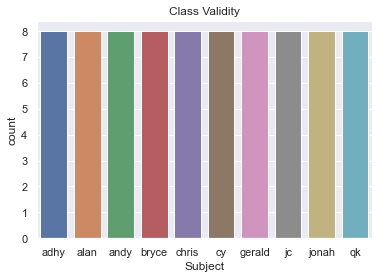

In [34]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [35]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']


In [36]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

dr_result = "Accuracy of the Model for DR dataset: " + str(match_header)
print(dr_result)

Accuracy of the Model for DR dataset: 29/80 (36.25%)


#### RESULT

In [37]:
print(ir_result)
print(dr_result)

Accuracy of the Model for IR dataset is: 32/80 (40.0%)
Accuracy of the Model for DR dataset: 29/80 (36.25%)


In [38]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:16:18
